- https://www.kaggle.com/haqishen/augmentation-methods-for-audio
- https://www.kaggle.com/CVxTz/audio-data-augmentation

In [4]:
import os
import sys
from glob import glob

import numpy as np
from librosa.feature import melspectrogram
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import cv2 # !pip install opencv-python

from config import TRAIN_PATH, TEST_PATH, OUTPUT_PATH
from vis_utils import show_spectrogram, show_wave
from preprocess_utils import list_wavs_fname, chop_audio

EPS = 1e-8

In [53]:
mel = librosa.feature.melspectrogram(wav, sr=sr, n_mels=200, hop_length=60, fmin=20, fmax=4000)
melgram = librosa.logamplitude(mel, ref_power=1.0)

(200, 267)


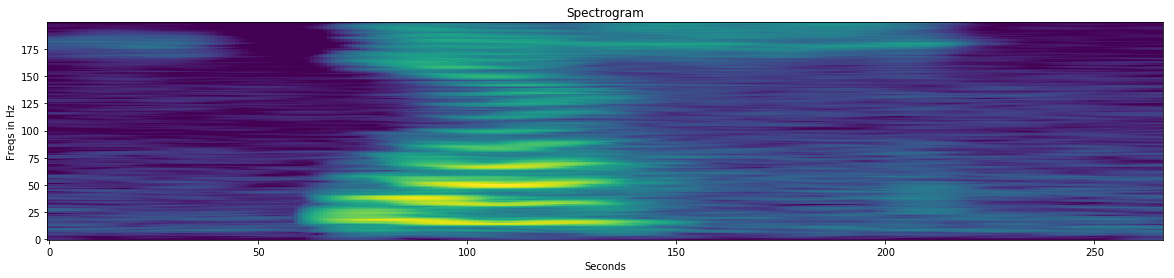

In [54]:
sample_rate=16000
figsize=(20, 4)
fig = plt.figure(figsize=figsize)
print(melgram.shape)
plt.imshow(melgram, aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Freqs in Hz')
plt.xlabel('Seconds')
plt.show()

(121, 267)


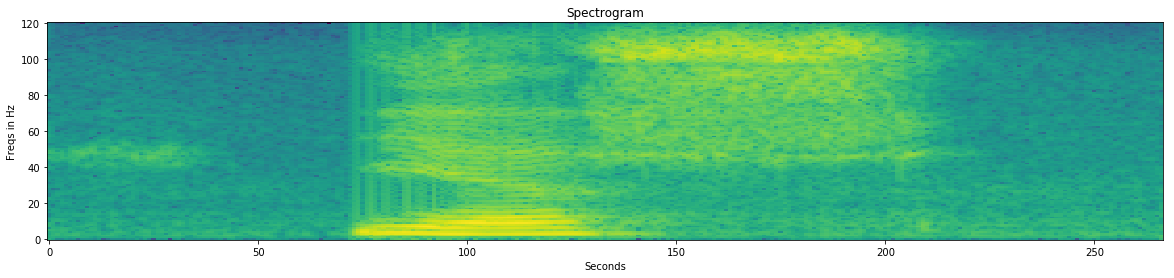

In [38]:
show_spectrogram(wav)

In [5]:
file_path = os.path.join(TRAIN_PATH, 'yes/0a7c2a8d_nohash_0.wav')

In [16]:
wav, sr = librosa.load(file_path, sr=None)

In [7]:
print(wav.shape, wav.max(), wav.min())

(16000,) 0.28720093 -0.19668579


In [8]:
ipd.Audio(wav, rate=sr)

In [ ]:
melgram = librosa.logamplitude(librosa.feature.melspectrogram(aud, sr=sr, n_mels=96),ref_power=1.0)[np.newaxis,np.newaxis,:,:]

# Practice

In [14]:
def log_specgram(wav, eps=1e-8):
    '''
    로그 스펙트로그램 변환
    '''
    D = librosa.stft(wav, n_fft=240, hop_length=60, win_length=240, window='hamming')
    spect, phase = librosa.magphase(D)
    return np.log(spect + eps)

def show_spectrogram(wav, sample_rate=16000, figsize=(20, 4)):
    spect = log_specgram(wav)
    print(spect.shape)
    fig = plt.figure(figsize=figsize)
    plt.imshow(spect, aspect='auto', origin='lower')
    plt.title('Spectrogram')
    plt.ylabel('Freqs in Hz')
    plt.xlabel('Seconds')
    plt.show()

## 1. Time shifting

In [7]:
start_ = int(np.random.uniform(-4800,4800))
print('time shift: ',start_)
if start_ >= 0:
    wav_time_shift = np.r_[wav[start_:], np.random.uniform(-0.001,0.001, start_)]
else:
    wav_time_shift = np.r_[np.random.uniform(-0.001,0.001, -start_), wav[:start_]]
ipd.Audio(wav_time_shift, rate=sr)

time shift:  -3931


(121, 267)


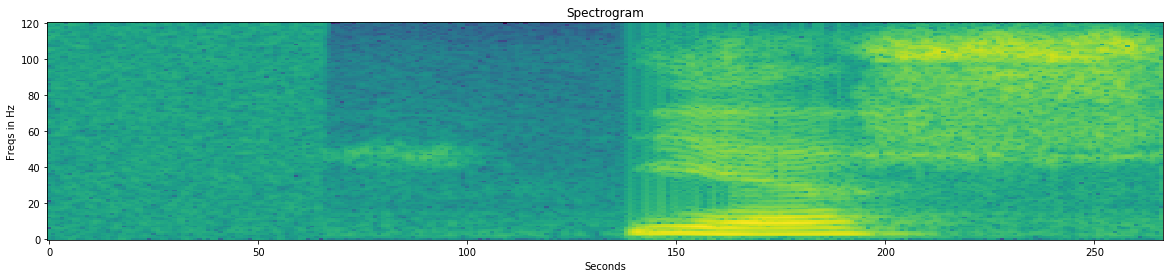

In [43]:
show_spectrogram(wav_time_shift)

(241, 201)


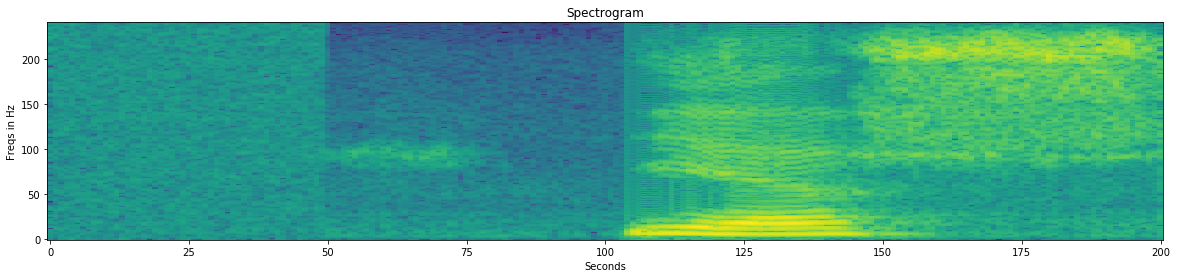

In [29]:
show_spectrogram(wav_time_shift)

## 2. Speed tuning

In [8]:
speed_rate = np.random.uniform(0.7,1.3)
wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()
print('speed rate: %.3f' % speed_rate, '(lower is faster)')
if len(wav_speed_tune) < 16000:
    pad_len = 16000 - len(wav_speed_tune)
    wav_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                           wav_speed_tune,
                           np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
else: 
    cut_len = len(wav_speed_tune) - 16000
    wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+16000]
print('wav length: ', wav_speed_tune.shape[0])
ipd.Audio(wav_speed_tune, rate=sr)

speed rate: 1.212 (lower is faster)
wav length:  16000


In [9]:
speed_rate = 2.0
wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()

In [10]:
len(wav), len(wav_speed_tune)

(16000, 32000)

In [11]:
cut_len = len(wav_speed_tune) - 16000

In [12]:
wav_speed_tune[int(cut_len/2):int(cut_len/2)+16000]

array([  3.05175781e-05,   3.05175781e-05,   3.05175781e-05, ...,
        -1.54876709e-03,   5.05828857e-03,   4.44030762e-03], dtype=float32)

(241, 201)


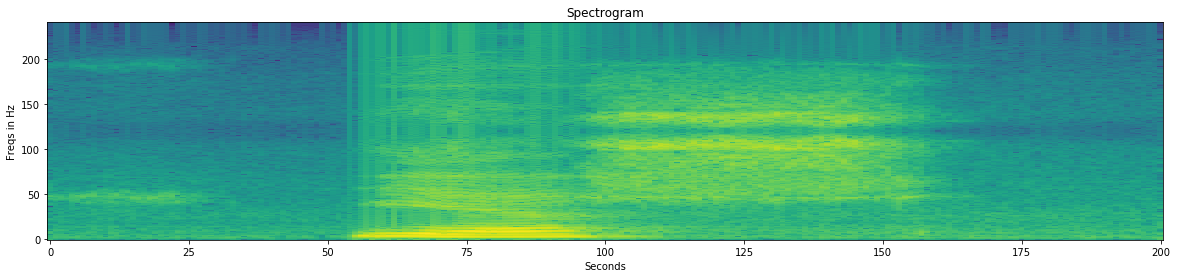

In [13]:
show_spectrogram(wav_speed_tune)

In [16]:
# 3 & 4. Mix background noise & volume tuning

In [17]:
# # bg_files = os.listdir('../input/train/audio/_background_noise_/')
# # bg_files.remove('README.md')
# chosen_bg_file = bg_files[np.random.randint(6)]
# bg, sr = librosa.load('../input/train/audio/_background_noise_/'+chosen_bg_file, sr=None)
# print(chosen_bg_file,'|', bg.shape[0], bg.max(), bg.min())
# ipd.Audio(bg, rate=sr) # !! be prepared when playing the noise, bacause it's so ANNOYING !!

# Data Augmentation

In [18]:
# %%time
# ## 각 폴더에 'nm_' 이 앞에붙은 노이즈믹싱된 파일 생성
# for label, fname in zip(labels, fnames):
#     if label == '_background_noise_':
#         sample_rate, samples = wavfile.read(os.path.join(TRAIN_PATH, label, fname))
#         for i, chopped_samples in enumerate(chop_audio(samples, L=16000, num=150)):
# #             if np.random.random() > 0.8: # 0.5의 확률로 노이즈믹싱
# #                 noise_amp = 5**abs(np.random.normal(0, 1.2))
# #                 noise_color = np.random.choice(['white', 'pink', 'blue', 'brown', 'violet'])
# #                 chopped_samples = noise_mixing(chopped_samples, sample_rate, noise_color, noise_amp)
# #             n_fname = 'nm_{}_{}'.format(i, fname)
#             n_fname = 'chopped_{}_{}'.format(i, fname)
#             wavfile.write(os.path.join(TRAIN_PATH, label, n_fname), sample_rate, chopped_samples)
            
# #     else: # 나머지 일반 label 일때,
# #         if np.random.random() > 0.5: # 0.5의 확률로 노이즈믹싱
# #             sample_rate, samples = wavfile.read(os.path.join(TRAIN_PATH, label, fname))
# #             noise_amp = 5**abs(np.random.normal(0, 1.2))
# #             noise_color = np.random.choice(['white', 'pink', 'blue', 'brown', 'violet'])
# #             samples = noise_mixing(samples, sample_rate, noise_color, noise_amp)
# #             n_fname = 'nm_' + fname
# #             wavfile.write(os.path.join(TRAIN_PATH, label, n_fname), sample_rate, samples)

In [19]:
labels, fnames = list_wavs_fname(TRAIN_PATH)

./input/train/audio/


In [24]:
%%time
## 각 폴더에 'chopped_' 이 앞에 붙은 1분씩 쪼개진 _background_noise_ 파일 생성.
for label, fname in zip(labels, fnames):
    if label == '_background_noise_':
        wav, sr = librosa.load(os.path.join(TRAIN_PATH, label, fname), sr=None)
        for i, chopped_wav in enumerate(chop_audio(wav, L=16000, num=250, speed_tuning=True, tuning_proba=0.7)):
            n_fname = 'chopped_{}_{}'.format(i, fname)
            librosa.output.write_wav(os.path.join(TRAIN_PATH, label, n_fname), chopped_wav, sr)

CPU times: user 37.8 s, sys: 208 ms, total: 38 s
Wall time: 11.1 s


In [23]:
# # 다시 원래대로 롤백하려면... ('nm_' 이 앞에 붙은 파일 제거)
# fpaths = glob(os.path.join(TRAIN_PATH, r'*/chopped_*' + 'wav'))
# print(len(fpaths))
# for fpath in fpaths:
#     os.remove(fpath)